<a href="https://colab.research.google.com/github/tatianabarbone/text-analytics/blob/master/text_analytics_ariana_grande.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using NLP Techniques and Text Analytics on Ariana Grande Lyrics

**Why is this project useful to me?**

> I've been an Ariana Grande fan since 2013. Since then, she has released five albums (and counting!) so I wanted to explore how her lyrics have changed over time.

**Project Overview:**

> In this notebook we're going to analyze the lyrical content of Ariana Grande's discography. We will perform EDA and extract important insights based on visualizations of the data.


**The code in this notebook does the following things:**
*   Retrieves song information by scraping data from the web using requests and BeautifulSoup
*   Structures and mungs data using pandas
*   Applies common NLP techniques such as sentiment analysis
*   Provides insightful visualizations with matplotlib


**We'll try to answer the following questions:**
*   How do Ariana Grande's songs and albums differ in terms of sentiment?
*   What are the most frequent words in her songs? Which bigrams does she use 
the most?



Hit "Run All" under the Runtime tab to run the notebook.


To start, we'll need to import a few packages.

In [1]:
# Imports
import re
import os 

import requests
from bs4 import BeautifulSoup

from collections import Counter, OrderedDict

import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer 

from wordcloud import WordCloud
from textblob import TextBlob

import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Then we'll specify the artist and create a dictionary mapping the album name to its discogs.com url. We'll include the number of top keywords we'd like to pull from each album.


In [2]:
ARTIST_NAME = 'Ariana grande'
ALBUM_DICT = {'Yours Truly': 'https://www.discogs.com/Ariana-Grande-Yours-Truly/master/593431',
               'My Everything': 'https://www.discogs.com/Ariana-Grande-My-Everything/master/723794',
               'Dangerous Woman': 'https://www.discogs.com/Ariana-Grande-Dangerous-Woman/master/1001638',
               'Sweetener': 'https://www.discogs.com/Ariana-Grande-Sweetener/master/1408887',
               'thank u next': 'https://www.discogs.com/Ariana-Grande-Thank-U-Next/master/1498712',
               'Positions': 'https://www.discogs.com/Ariana-Grande-Positions/master/1831958'}

KEYS_PER_ALBUM = 25

We'll store the names of each album and their urls in two lists.

In [3]:
album_names = []
discog_urls = []
for album in ALBUM_DICT:
  album_names.append(album)
  discog_urls.append(ALBUM_DICT[album])

print(album_names)
print(discog_urls)

['Yours Truly', 'My Everything', 'Dangerous Woman', 'Sweetener', 'thank u next', 'Positions']
['https://www.discogs.com/Ariana-Grande-Yours-Truly/master/593431', 'https://www.discogs.com/Ariana-Grande-My-Everything/master/723794', 'https://www.discogs.com/Ariana-Grande-Dangerous-Woman/master/1001638', 'https://www.discogs.com/Ariana-Grande-Sweetener/master/1408887', 'https://www.discogs.com/Ariana-Grande-Thank-U-Next/master/1498712', 'https://www.discogs.com/Ariana-Grande-Positions/master/1831958']


###Data Collection with Web Scraping

Before we analyze the song lyrics, we need to get the text from the web. Luckily, **BeautifulSoup** makes it easy to pull the data we need out of an HTML file.

To find the song names, we will parse text from the HTML table on discogs.com.

*Note:* One of the HTML pages I examined had a different format from the rest ("My Everything"), so I accounted for that in the function. 




In [4]:
#returns list of songs per album url
def getSongTitles(url):

    page = requests.get(url)
    html = BeautifulSoup(page.text, 'html.parser')
    titles = []
    table = html.find('table', attrs={'class':'playlist'})
    rows = table.find_all('tr') 
    
    for row in rows:
        cols = row.find_all('td')
        cols = [cell.text.strip() for cell in cols]
        titles.append([cell for cell in cols if cell]) 
    
    return [t[1] for t in titles] if 'My-Everything' in url else [t[0] for t in titles]


Pre-process the lyrics and remove anything that is not an actual lyric.

In [5]:
def cleanLyrics(lyrics):
    
    # Remove identifiers like chorus, verse, etc
    lyrics = re.sub(r'[\(\[].*?[\)\]]', '', lyrics)
    # Remove empty lines
    lyrics = os.linesep.join([s for s in lyrics.splitlines() if s])   
    lyrics = lyrics.replace("\n", " ")      
    
    return lyrics

Now we can web scrape genius.com by using the requests library and BeautifulSoup.

In [6]:
def lyricScraper(url):
    
    try:
      page = requests.get(url)
      html = BeautifulSoup(page.text, 'html.parser')
      lyrics = ""
      found = html.find('div', attrs={'class':'lyrics'}).find_all('p')
      for p in found:
        lyrics += (p.text)
      lyrics = cleanLyrics(lyrics) 
    except:
      return "Song is invalid"
    return lyrics

Before we generate the genius url from the song name returned to us by **getSongTitles()**, we need to prepare the title of each song so we can turn it into a valid Genius-formatted url.

In [7]:
#prep song name for genius url schema
def cleanTitle(song_name):
  # Removes all and any of the following: forward slash, apostrophe, periods,
  # parenthesis, and punctuation (commas, apostrophe, question mark, 
  # exclamation, colon, semicolon, ampersand) 
  song_name = re.sub(r"[?!;:,'’\.\/\)\()\]\[]", '', song_name)

  return song_name

Genius' url schema isn't too verbose, so we'll (usually) be able to make a request using just the artist and the name of the song. 

*Note:* If you the artist you are using has collaborated with another artist on a song, you may need to manually change the generated url since genius may have altered the artist name.

*   In my case, there were a few songs that did not match the general schema because of a collaboration.






In [8]:
def urlGenerator(song_name):
    
    song_name = cleanTitle(song_name)
    
    domain_name = 'https://genius.com/'
    artist_name = ARTIST_NAME
  
    #special cases

    if song_name == 'Almost Is Never Enough': 
        artist_name = 'Ariana grande and nathan sykes'
    elif song_name == 'Popular Song':
        artist_name = 'Mika'
        song_name = 'Popular Song Single Version'
    elif song_name == 'Motive':
        artist_name = 'Ariana grande and doja cat'
    elif song_name == 'Off The Table':
        artist_name = 'Ariana grande and the weeknd'
    

    url = domain_name + artist_name + " " + song_name + " lyrics"
    url = url.replace("  ", "-") #special case: two spaces
    url = url.replace(" ", "-")
    url = url.replace("+", "-")

    return url

Here's a helper function we'll use to extract the song title from a given url.

In [9]:
def extractSongTitle(url):

    if 'Mika' in url:
      return 'Popular-Song'
    elif 'nathan' in url:
      return 'Almost-Is-Never-Enough'
    elif 'doja' in url:
      return 'Motive'
    elif 'Off-The-Table' in url:
      return 'Off-The-Table'
    else:
      found = re.search('https:\/\/genius.com/Ariana-grande-(.+?)-lyrics', url).group(1)
    return found

We'll compile the song titles for each album in **album_songs**, and the urls in **album_urls**.

In [10]:
# List of lists containing all songs in each album
album_songs = [getSongTitles(album_url) for album_url in discog_urls]
print("Album songs: ",album_songs)

album_urls = album_songs[:]

# Loop over all chosen songs, get their urls and swap name of song for url
for album in range(len(album_urls)):
    for song in range(len(album_urls[album])):
        album_urls[album][song] = urlGenerator(album_urls[album][song])

#print("Album urls: ",album_urls)

Album songs:  [['Honeymoon Avenue', 'Baby I', 'Right There', 'Tattooed Heart', "Lovin' It", 'Piano', "Daydreamin'", 'The Way', 'You’ll Never Know', 'Almost Is Never Enough', 'Popular Song', 'Better Left Unsaid'], ['Intro', 'Problem', 'One Last Time', 'Why Try', 'Break Free', 'Best Mistake', 'Be My Baby', 'Break Your Heart Right Back', 'Love Me Harder', 'Just A Little Bit Of Your Heart', 'Hands On Me', 'My Everything'], ['Moonlight', 'Dangerous Woman', 'Be Alright', 'Into You', 'Side To Side', 'Let Me Love You', 'Greedy', 'Leave Me Lonely', 'Everyday', 'Sometimes', "I Don't Care", 'Bad Decisions', 'Touch It', 'Knew Better / Forever Boy', "Thinkin' 'Bout You"], ['Raindrops (An Angel Cried)', 'Blazed', 'The Light Is Coming', 'R.E.M', 'God Is A Woman', 'Sweetener', 'Successful', 'Everytime', 'Breathin', 'No Tears Left To Cry', 'Borderline', 'Better Off', 'Goodnight N Go', 'Pete Davidson', 'Get Well Soon'], ['Imagine', 'Needy', 'NASA', 'Bloodline', 'Fake Smile', 'Bad Idea', 'Make Up', 'Ghos

##Structuring the Data

By providing all of the album urls we compiled above (**album_urls**) and the index of the album we want to look at, we can make a dictionary mapping song name to url. Then we can use pandas to easily convert the dictionary to a dataframe for efficient manipulation.

In [11]:
# Get dicts for each album, scrape lyrics for each song
def dictGenerator(album_urls):

  album_dict = {extractSongTitle(album_urls[album]): lyricScraper(album_urls[album]) for album in range(len(album_urls))}

  return album_dict
  
  
#Compile all dicts
all_dicts = []
# a dict consists of song name: song url
for album in range(len(album_urls)):
  album_dict = dictGenerator(album_urls[album])
  all_dicts += [album_dict]

df = pd.DataFrame(all_dicts[0].items(), columns=['song', 'lyrics'])
print(df)

                      song                                             lyrics
0         Honeymoon-Avenue  Shoo-doo-doo-dum-doo, da-da Shoo-doo-doo-dum-d...
1                   Baby-I  Baby, I got love for thee so deep inside of me...
2              Right-There  Ooh-ooh, hey Put your hands up  So put your ha...
3           Tattooed-Heart  You don't need a lot of money Honey, you don't...
4                 Lovin-It  It's The Rascals! Baby, don’t you know you’ve ...
5                    Piano  Oh-oh-oh-oh Oh-oh-oh-oh Here we go I could wri...
6               Daydreamin  You walked in Caught my attention I've never s...
7                  The-Way  What we gotta do right here is go back Back in...
8         Youll-Never-Know  Now you finally tell me how you feel Guess you...
9   Almost-Is-Never-Enough  I'd like to say we gave it a try I'd like to b...
10            Popular-Song  You were the popular one, the popular chick It...
11      Better-Left-Unsaid  I told you once, "Get out my life I 

## Sentiment Analysis


We will use TextBlob to get polarity and subjectivity scores and add those fields to our dataframe.


Before we do that, we will need to use simple helper function that converts a list of words to a string.

In [12]:
def joinWords(album_dict):

  # Store all words from the list in a string
  all_words = ' '.join([album_dict.get(song) for song in album_dict])

  return all_words

**getSentiment()** will display the polarity and subjectivity scores for a piece of text. We will use this function to compare these scores for albums and then individual songs.

*   The polarity score is a float within the range [-1.0, 1.0] where -1.0 is very negative and 1.0 is very positive.
*   The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

Let's get the average sentiment for each album.


In [13]:
def getSentiment(album_dict):

  all_words = joinWords(album_dict)

  print("Subjectivity:", TextBlob(all_words).sentiment.subjectivity)
  print("Polarity:", TextBlob(all_words).sentiment.polarity)

for album in range(len(all_dicts)):
  print("Album #", album+1)
  getSentiment(all_dicts[album])

Album # 1
Subjectivity: 0.5463095941508194
Polarity: 0.15499779932231203
Album # 2
Subjectivity: 0.415959667294413
Polarity: 0.041575429435598915
Album # 3
Subjectivity: 0.565562710270229
Polarity: 0.11347432743672284
Album # 4
Subjectivity: 0.46844805943979534
Polarity: 0.15735983904372317
Album # 5
Subjectivity: 0.5389866442838998
Polarity: 0.058994793316439705
Album # 6
Subjectivity: 0.5545792362399506
Polarity: 0.11233551501408656


The albums seem to stay at a similar level of subjectivy over time. With all albums having a polarity score between 0.04 and 0.16, the albums are slightly more positive than negative.

### Assembling the Dataframe

Now we are going to get the sentiment score on each song and create a scatterplot.

We'll draw two new additional columns in our dataframe for polarity and subjectivity.

In [14]:
# Assemble each album df in order
frames = []
for album in range(len(all_dicts)):
  df = pd.DataFrame(all_dicts[album].items())
  frames.append(df)

result = pd.concat(frames)

data = result.rename(columns={0:'song', 1:'lyrics'})

# Flatten the list for easy access when labeling plot points
flat_list = []
for sublist in album_songs:
    for item in sublist:
        flat_list.append(extractSongTitle(item))
        
flat_list = [re.sub("-"," ",item) for item in flat_list]
print(flat_list)

['Honeymoon Avenue', 'Baby I', 'Right There', 'Tattooed Heart', 'Lovin It', 'Piano', 'Daydreamin', 'The Way', 'Youll Never Know', 'Almost Is Never Enough', 'Popular Song', 'Better Left Unsaid', 'Intro', 'Problem', 'One Last Time', 'Why Try', 'Break Free', 'Best Mistake', 'Be My Baby', 'Break Your Heart Right Back', 'Love Me Harder', 'Just A Little Bit Of Your Heart', 'Hands On Me', 'My Everything', 'Moonlight', 'Dangerous Woman', 'Be Alright', 'Into You', 'Side To Side', 'Let Me Love You', 'Greedy', 'Leave Me Lonely', 'Everyday', 'Sometimes', 'I Dont Care', 'Bad Decisions', 'Touch It', 'Knew Better Forever Boy', 'Thinkin Bout You', 'Raindrops An Angel Cried', 'Blazed', 'The Light Is Coming', 'REM', 'God Is A Woman', 'Sweetener', 'Successful', 'Everytime', 'Breathin', 'No Tears Left To Cry', 'Borderline', 'Better Off', 'Goodnight N Go', 'Pete Davidson', 'Get Well Soon', 'Imagine', 'Needy', 'NASA', 'Bloodline', 'Fake Smile', 'Bad Idea', 'Make Up', 'Ghostin', 'In My Head', '7 Rings', 'Tha

Applying the anonymous functions, we'll get two new columns. Let's take a look at our dataframe. 

In [15]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data['polarity'] = data['lyrics'].apply(pol)
data['subjectivity'] = data['lyrics'].apply(sub)

data.index = range(len(data.index)) #reset dataframe indices

print(data)

                song  ... subjectivity
0   Honeymoon-Avenue  ...     0.392956
1             Baby-I  ...     0.732574
2        Right-There  ...     0.527534
3     Tattooed-Heart  ...     0.435714
4           Lovin-It  ...     0.631250
..               ...  ...          ...
75         West-Side  ...     0.508917
76     Love-Language  ...     0.609910
77         Positions  ...     0.558838
78           Obvious  ...     0.593834
79               POV  ...     0.687446

[80 rows x 4 columns]


Using matplotlib we will customize the plot to match the aesthetic of Ariana's album, "Thank U Next".

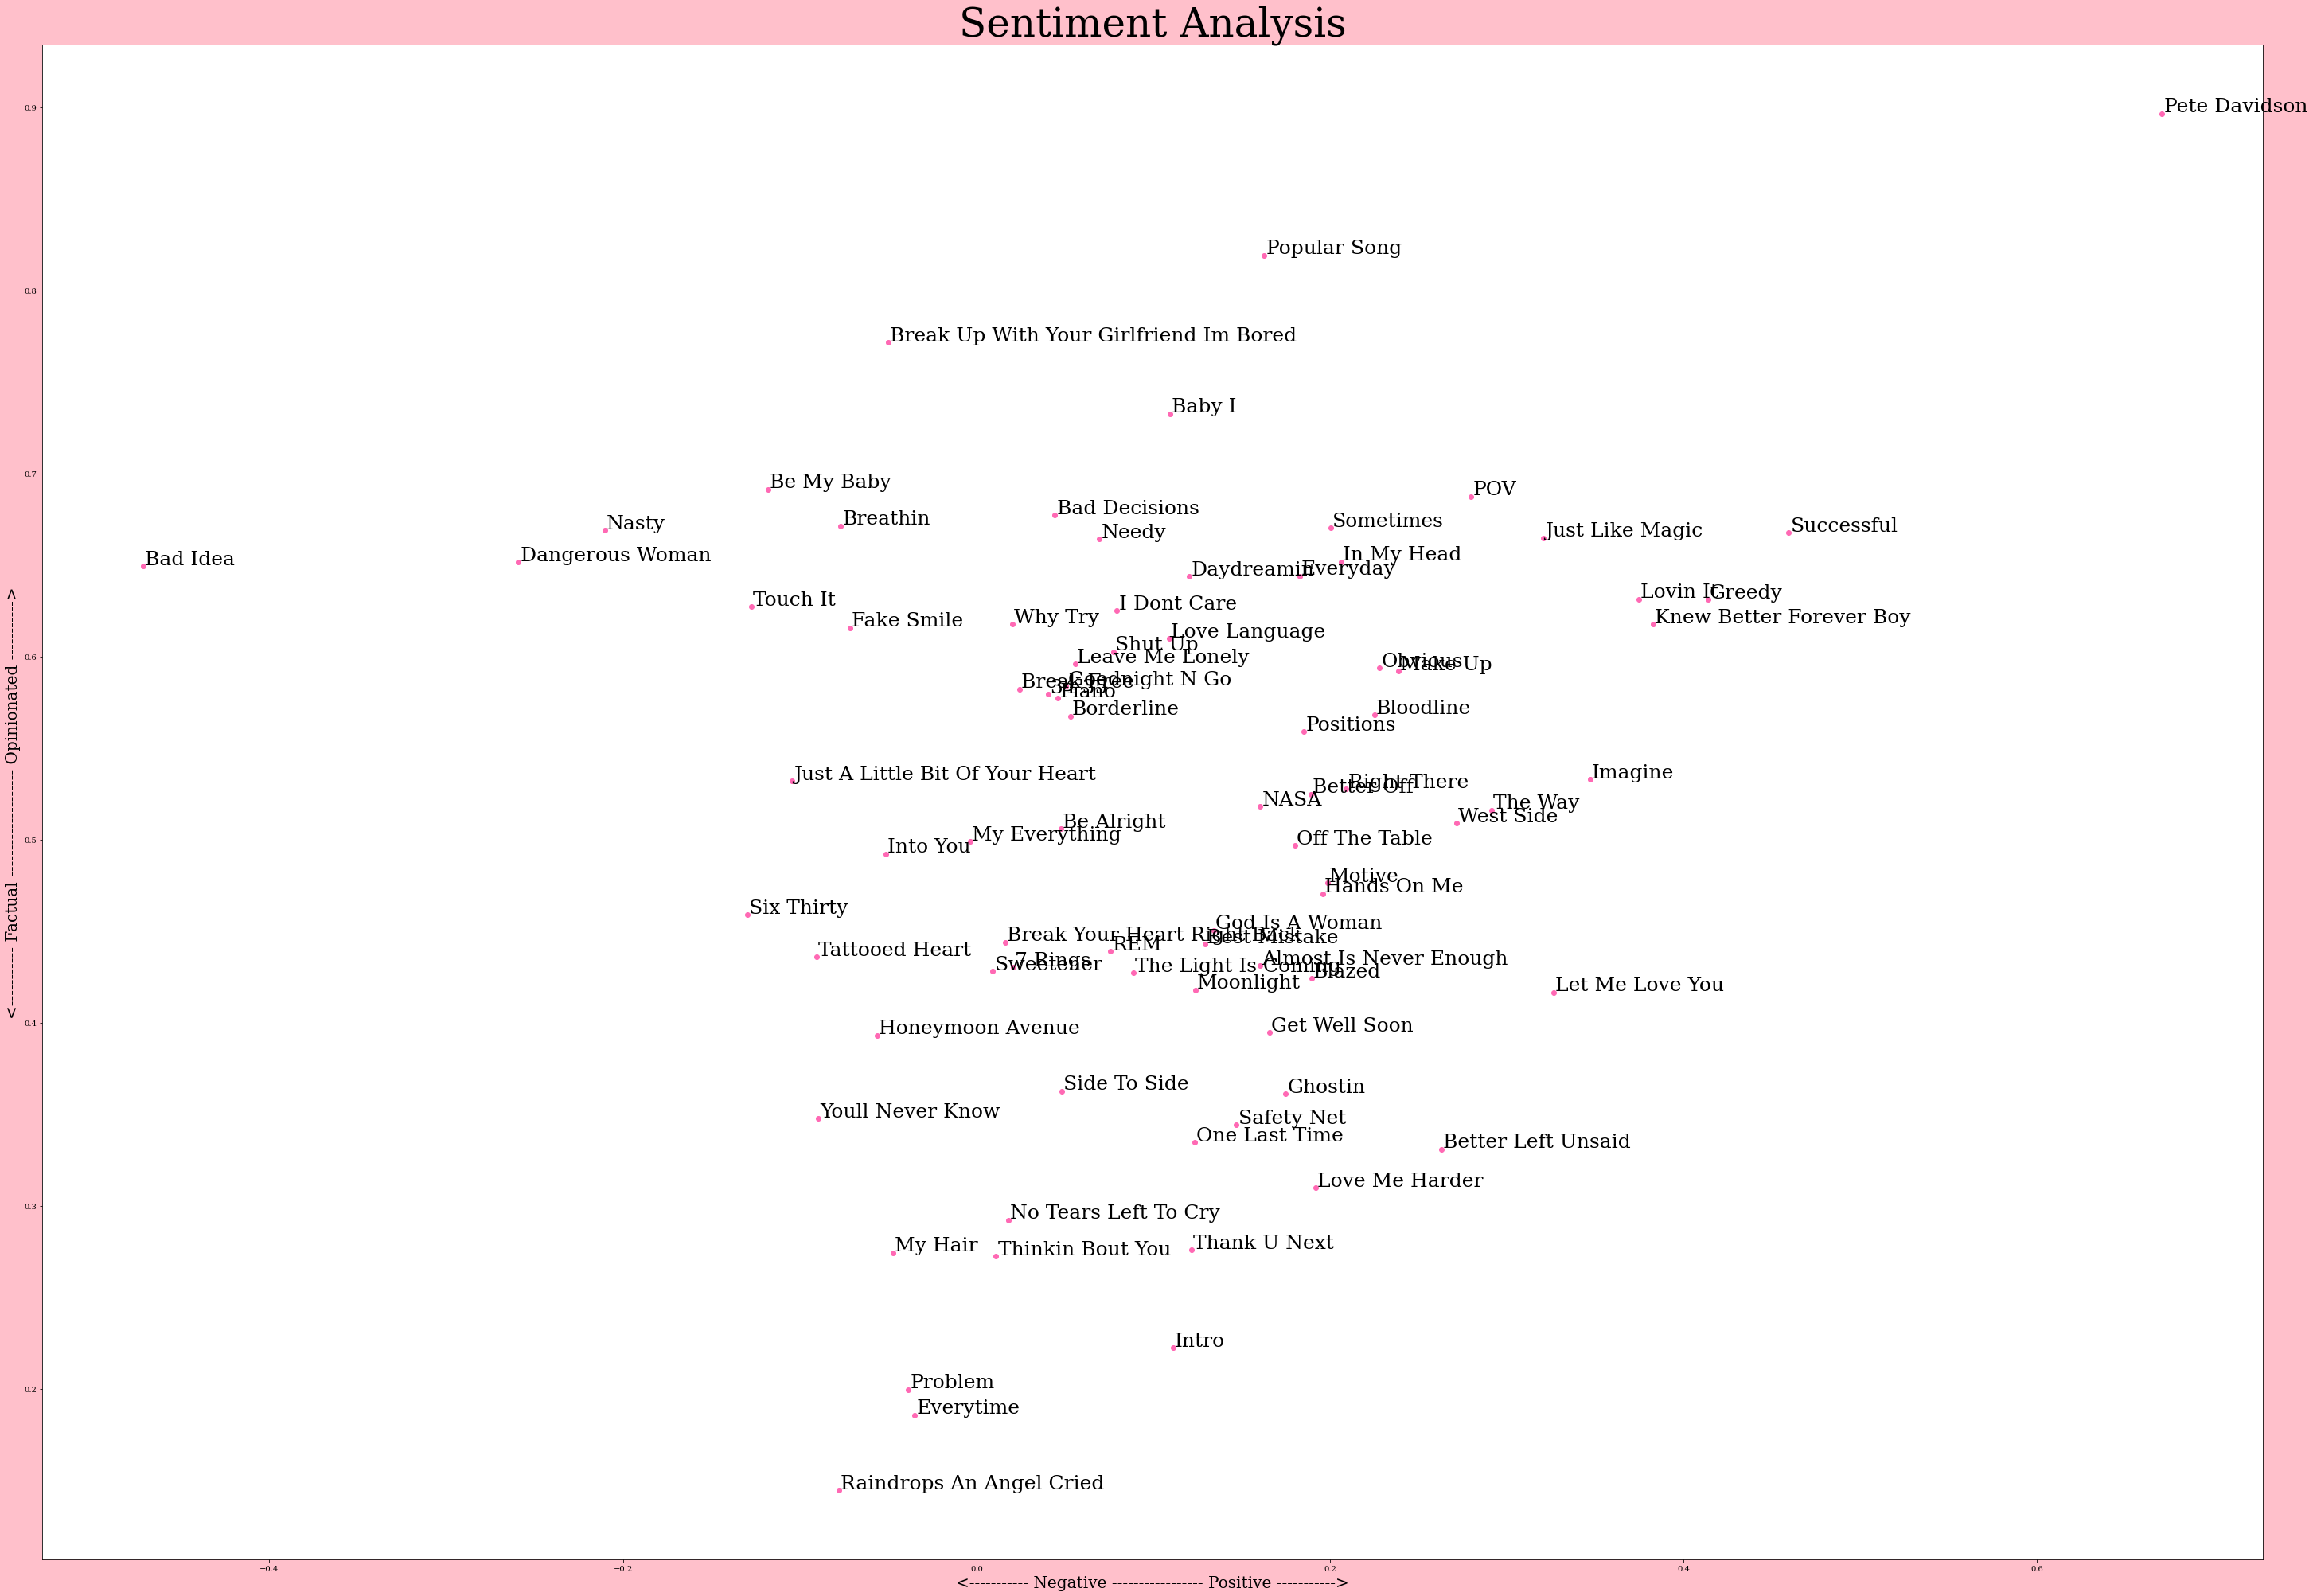

In [16]:
plt.rcParams['figure.figsize'] = [50,35]
plt.rcParams["font.family"] = "serif" 
plt.rcParams["figure.facecolor"] = 'pink'

for index, row in enumerate(data.index): 
    x = data.polarity.loc[row]
    y = data.subjectivity.loc[row]

    plt.scatter(x, y, color='hotpink')
    plt.text(x+.001, y+.001, flat_list[row], fontsize=25)


plt.title('Sentiment Analysis', fontsize=50)
plt.xlabel('<----------- Negative ----------------- Positive ----------->', fontsize=20)
plt.ylabel('<----------- Factual -------------------- Opinionated ----------->', fontsize=20)


plt.show()
plt.close()


There appear to be clusters of similar songs, for example, "Break Your Heart Right Back", "7 Rings" and "Sweetener".

#### Addressing the Outlier



It looks like we have at least one outlier. Let's take a look at why the song "Pete Davidson" is more positive and subjective than the rest.

First, with the help of nltk we'll add stopwords and tokenize the text.

In [17]:
def getTokens(album_dict):

  # We'll be calling this function with different inputs
  all_words = joinWords(album_dict) if type(album_dict) is not str else album_dict

  # Declare stop words
  all_stopwords = nltk.corpus.stopwords.words('english')
  all_stopwords.append(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '/'])    
  
  # Extracts sequences of alphanumeric characters as tokens and drop trailing punctuation
  tokenizer = RegexpTokenizer(r'\w+')
  all_tokens = tokenizer.tokenize(all_words)

  # Remove stop words
  all_tokens = [token.lower() for token in all_tokens if token.lower() not in all_stopwords]

  return all_tokens

def getTopKeywords(tokens, num):
  return Counter(tokens).most_common(num)

Calling **getTopKeywords()** will return the top *num* keywords in the song. Let's locate the cell in our dataframe with the lyrics and get the top five keywords.

In [18]:
pete_lyrics = data.loc[data.song == 'Pete-Davidson','lyrics'].tolist()[0]
print(pete_lyrics)
pete_tokens = getTokens(pete_lyrics)
getTopKeywords(pete_tokens, 5)

Mmm, yeah, yuh I thought you into my life , look at my mind  No better place or a time,  how they align Universe must have my back, fell from the sky into my lap And I know you know that you're my soulmate and all that I’m like ooh, ooh, my whole life got me ready for you, ooh, ooh Got me happy, happy I'ma be happy, happy, yeah I'ma be happy, happy Won’t get no crying from me, yeah Gonna be happy, happy I'ma be happy, happy  I'ma be happy, happy, yeah Gonna be happy, happy I'ma be happy, happy I'ma be happy, happy, yeah Gonna be happy, happy I'ma be happy, happy I'ma be happy, happy


[('happy', 24), ('yeah', 5), ('ooh', 4), ('gonna', 3), ('life', 2)]

Interesting. The word 'happy' is sung 24 times, causing a high polarity score. 

### Album Sentiment Comparison

Does Ariana tend to stay positive throughout the album, or does she have some low points? In this section, we are going to take a look at the order of songs in each album and plot the sentiment over time.

In [19]:
def sentimentByAlbum(df, sentiment):

  # Get polarity or subjectivity column
  pol = df[sentiment]

  all_albums = []

  # Get how many songs are on each album so we know where 
  # to index the dataframe
  album1 = len(all_dicts[0])
  album2 = len(all_dicts[1])
  album3 = len(all_dicts[2])
  album4 = len(all_dicts[3])
  album5 = len(all_dicts[4])
  album6 = len(all_dicts[5])

  all_albums.append( pol[0:album1].tolist() )
  all_albums.append( pol[album1: (album1 + album2) ].tolist() )
  
  all_albums.append( pol[(album1 + album2): 
              (album1 + album2 + album3)].tolist() )

  all_albums.append( pol[(album1 + album2 + album3): 
              (album1 + album2 + album3 + album4)].tolist() )

  all_albums.append( pol[ (album1 + album2 + album3 + album4) : 
              (album1 + album2 + album3 + album4 + album5)].tolist() )
  
  all_albums.append( pol[ (album1 + album2 + album3 + album4 + album5): 
              (album1 + album2 + album3 + album4 + album5 + album6)].tolist() )

  #return the df so we can access each col later
  return all_albums

We'll call **findMaxList()** to find the longest album and plot the right number of x-axis ticks. Then we'll create a new dataframe from our data with empty values to account for the shorter albums.

Let's examine the polarity scores first.

      album1    album2    album3    album4    album5    album6
0  -0.056349  0.111111  0.123810 -0.077778  0.347059  0.077453
1   0.109386 -0.038475 -0.259091  0.189462  0.069618  0.040800
2   0.209158  0.123333  0.047619  0.088577  0.160417  0.198611
3  -0.090476  0.020236 -0.051190  0.075921  0.225096  0.320752
4   0.374479  0.024451  0.048052  0.134188 -0.071512  0.180094
5   0.046016  0.129365  0.326499  0.009226 -0.471333 -0.129818
6   0.120513 -0.117857  0.413793  0.459427  0.238839  0.147076
7   0.291412  0.016277  0.055983 -0.034894  0.175000 -0.047222
8  -0.089667  0.191818  0.182692 -0.076852  0.206140 -0.210330
9   0.160468 -0.104405  0.200260  0.018155  0.020782  0.271641
10  0.162789  0.195962  0.079545  0.053095  0.121460  0.108996
11  0.262847 -0.003571  0.044431  0.189167 -0.050000  0.185101
12       NaN       NaN -0.127273  0.050654       NaN  0.228022
13       NaN       NaN  0.382919  0.670690       NaN  0.279870
14       NaN       NaN  0.011111  0.165631       NaN   

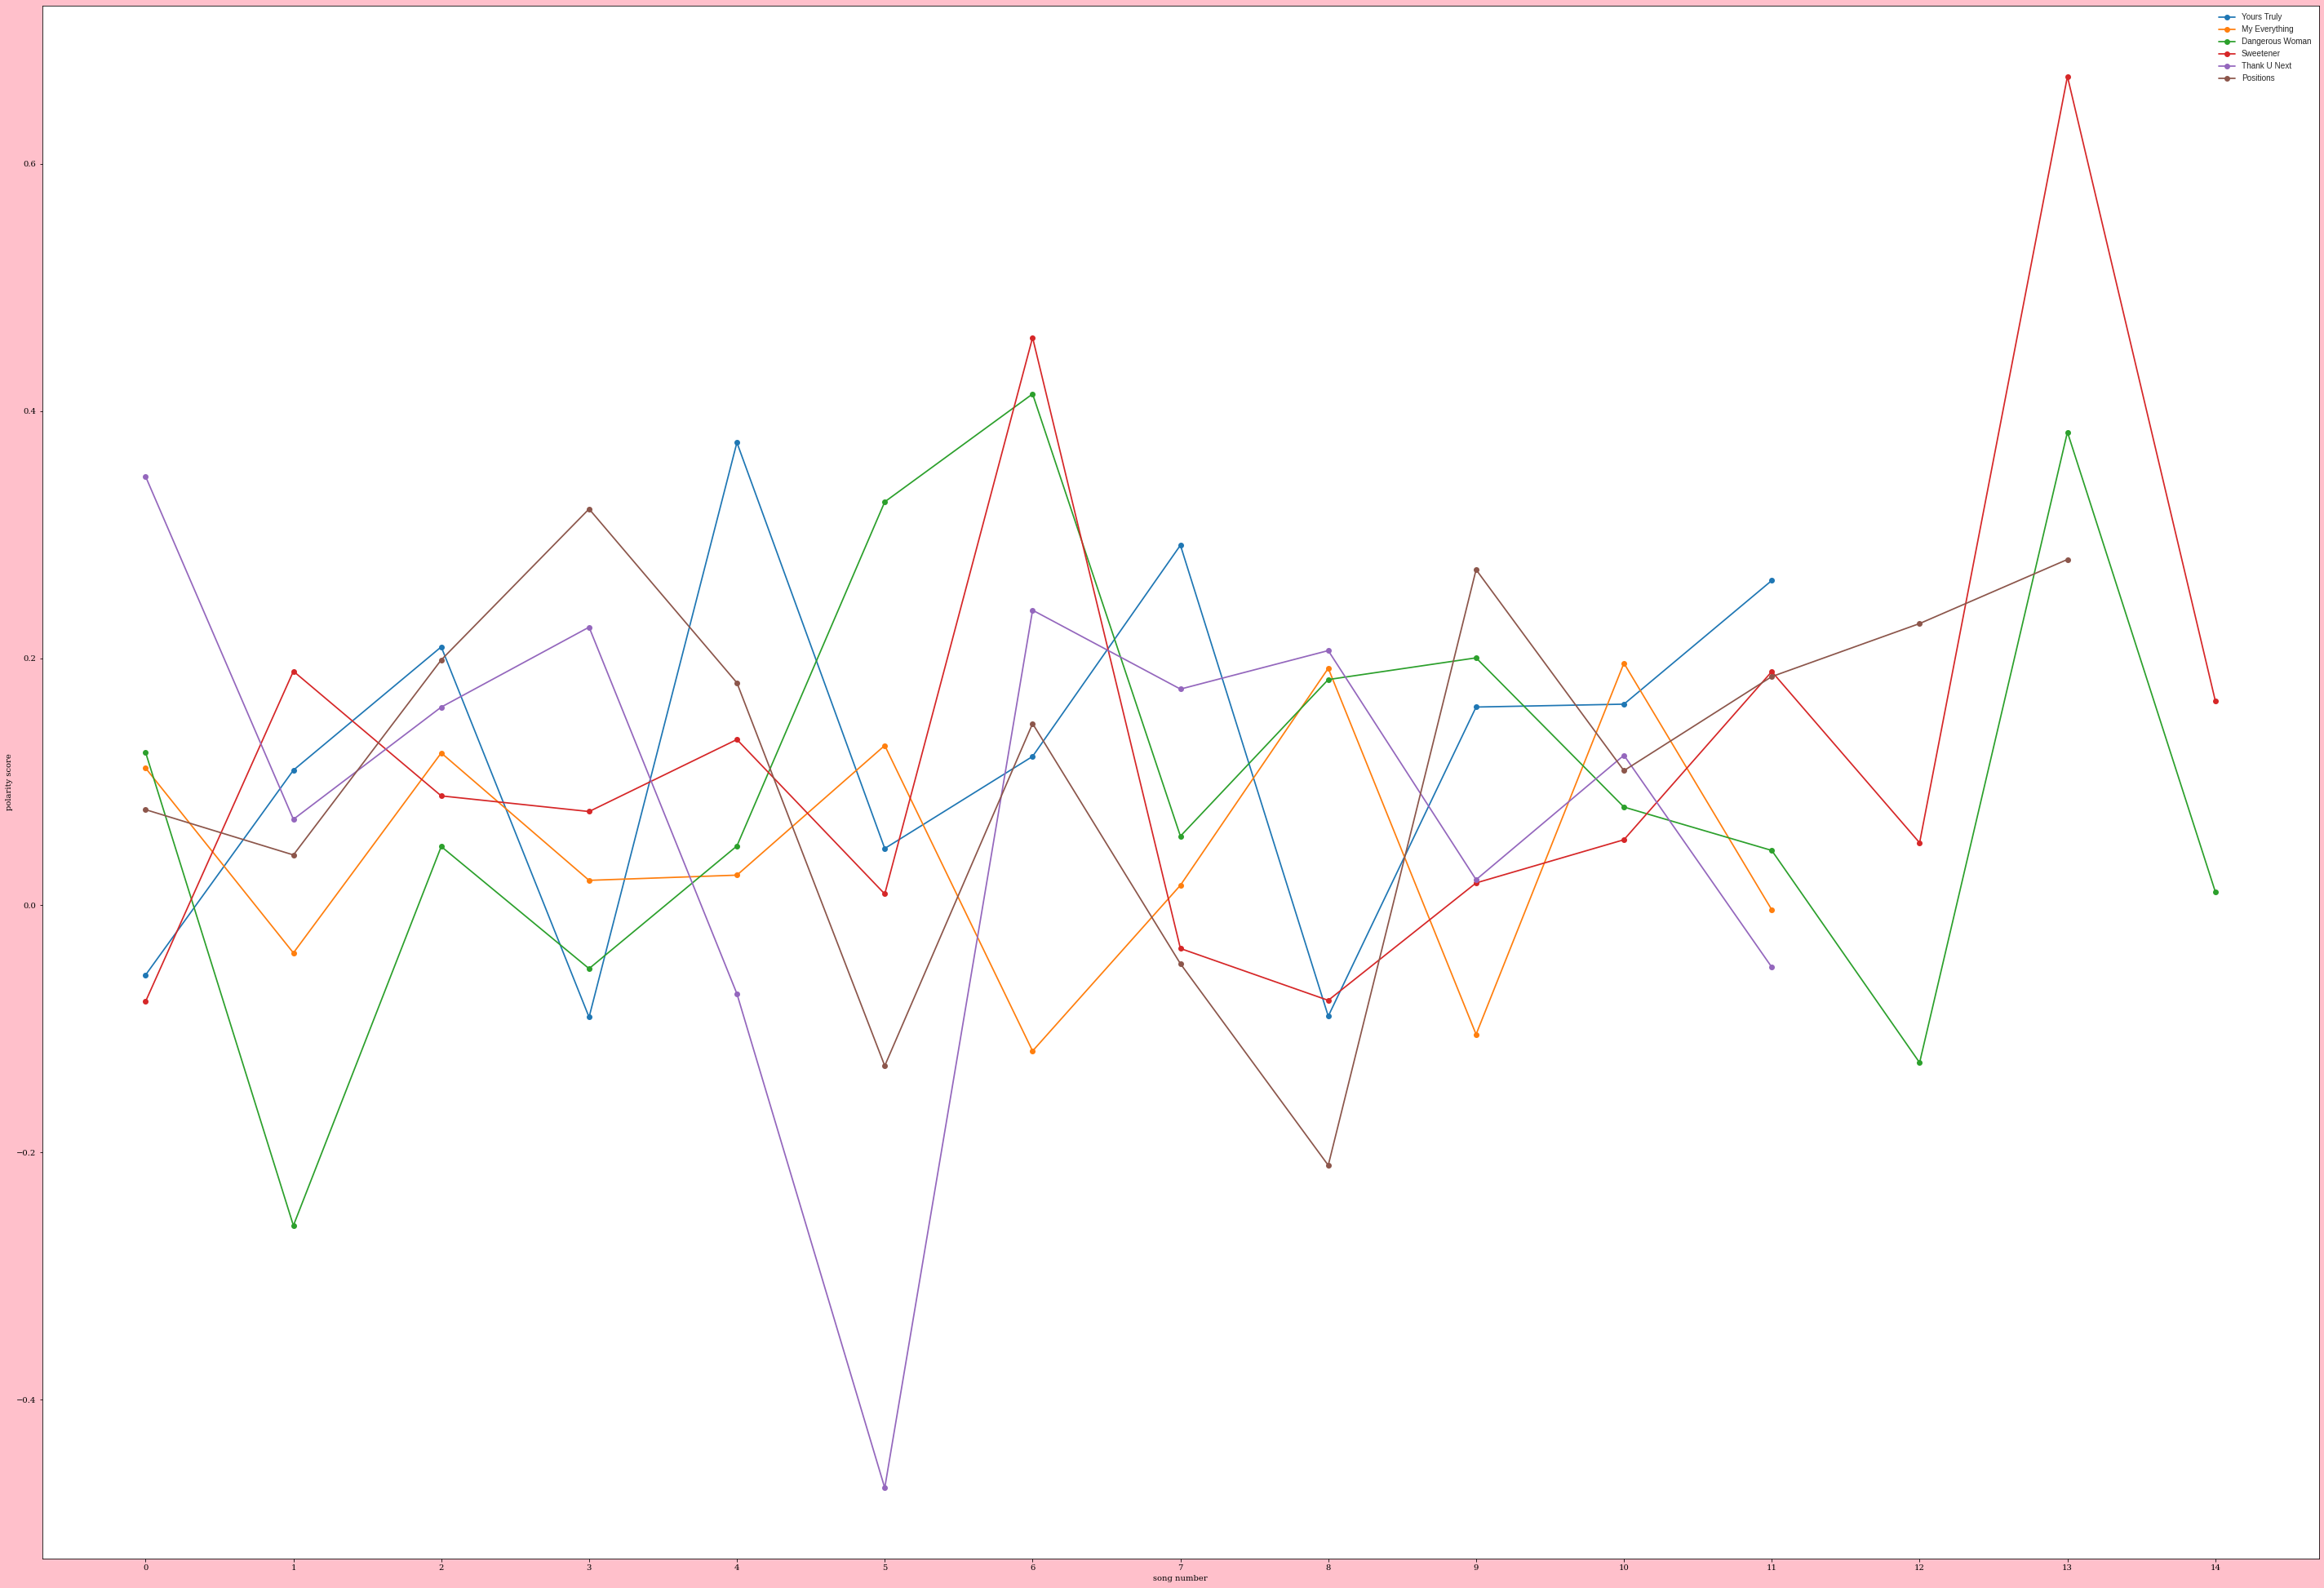

In [20]:
def findMaxList(list):
  list_len = [len(sublist) for sublist in list]
  return max(list_len)

def fillNaN(df, all_albums):
  df = pd.DataFrame.from_dict({'album1': all_albums[0], 'album2': all_albums[1],
                             'album3': all_albums[2], 'album4': all_albums[3],
                            'album5': all_albums[4], 'album6': all_albums[5]}, orient='index').T

  #fill shorter albums with NaN values
  df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in df.items() ]))

  #Let's take a look at our new dataframe
  print(df)

  return df

def drawLinePlot(df, sentiment):
  
  all_albums = sentimentByAlbum(data, sentiment) 
  df = fillNaN(df, all_albums)
  longest_album_len = findMaxList(all_albums)

  plt.xticks(np.arange(0, longest_album_len, 1.0))
  plt.ylabel(sentiment + ' score')
  plt.xlabel('song number')
  plt.style.use('seaborn')

  plt.plot(df.index, df['album1'].tolist(), marker='o', label='Yours Truly')
  plt.plot(df.index, df['album2'].tolist(), marker='o', label='My Everything')
  plt.plot(df.index, df['album3'].tolist(), marker='o', label='Dangerous Woman')
  plt.plot(df.index, df['album4'].tolist(), marker='o', label='Sweetener')
  plt.plot(df.index, df['album5'].tolist(), marker='o', label='Thank U Next')
  plt.plot(df.index, df['album6'].tolist(), marker='o', label='Positions')
  

  plt.legend()
  plt.show()
  
drawLinePlot(data, 'polarity')

It looks like most of the albums stay in the [-0.2,0.4] range of polarity with some exceptions. 

What's the fifth song on "Thank U Next"? On the bottom of the plot we can see that "Bad Idea" causes a sharp drop in polarity. 

Let's take a look at *Dangerous Woman* (yellow) and *Sweetener* (purple) individually as they seem to have similar polarity scores.

In [21]:
def highlightAlbums(data, highlight1, highlight2, sentiment):
  all_albums = sentimentByAlbum(data, sentiment)
  sentiment_df = fillNaN(data, all_albums)

  # Plot all the other lines in grey
  for column in sentiment_df.columns:
    plt.plot(sentiment_df.index, sentiment_df[column].tolist(), marker='', color='grey', linewidth=1, alpha=0.4)

  # Plot the similar albums in bright colors
  plt.plot(sentiment_df.index, sentiment_df[highlight1].tolist(), marker='', color='orange', linewidth=4, alpha=0.7)
  plt.plot(sentiment_df.index, sentiment_df[highlight2].tolist(), marker='', color='purple', linewidth=4, alpha=0.7)
  

      album1    album2    album3    album4    album5    album6
0  -0.056349  0.111111  0.123810 -0.077778  0.347059  0.077453
1   0.109386 -0.038475 -0.259091  0.189462  0.069618  0.040800
2   0.209158  0.123333  0.047619  0.088577  0.160417  0.198611
3  -0.090476  0.020236 -0.051190  0.075921  0.225096  0.320752
4   0.374479  0.024451  0.048052  0.134188 -0.071512  0.180094
5   0.046016  0.129365  0.326499  0.009226 -0.471333 -0.129818
6   0.120513 -0.117857  0.413793  0.459427  0.238839  0.147076
7   0.291412  0.016277  0.055983 -0.034894  0.175000 -0.047222
8  -0.089667  0.191818  0.182692 -0.076852  0.206140 -0.210330
9   0.160468 -0.104405  0.200260  0.018155  0.020782  0.271641
10  0.162789  0.195962  0.079545  0.053095  0.121460  0.108996
11  0.262847 -0.003571  0.044431  0.189167 -0.050000  0.185101
12       NaN       NaN -0.127273  0.050654       NaN  0.228022
13       NaN       NaN  0.382919  0.670690       NaN  0.279870
14       NaN       NaN  0.011111  0.165631       NaN   

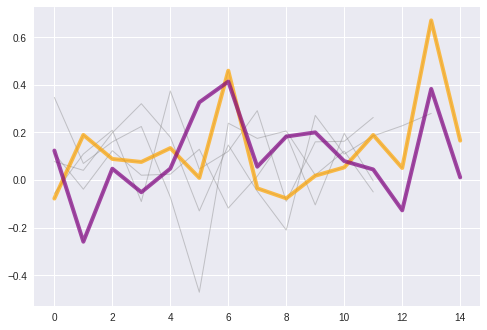

In [22]:
highlightAlbums(data, 'album4', 'album3', 'polarity')

Now let's look at subjectivity.

      album1    album2    album3    album4    album5    album6
0   0.392956  0.222222  0.417857  0.144444  0.532956  0.602671
1   0.732574  0.199589  0.651515  0.424030  0.664236  0.579350
2   0.527534  0.334667  0.505952  0.427212  0.517940  0.476389
3   0.435714  0.617593  0.492171  0.438937  0.568008  0.664776
4   0.631250  0.582143  0.362554  0.450427  0.615586  0.496836
5   0.577048  0.442778  0.416442  0.427976  0.649333  0.458812
6   0.643590  0.691353  0.631034  0.667696  0.591964  0.344152
7   0.516114  0.443842  0.595726  0.185640  0.361111  0.274306
8   0.347667  0.309697  0.643910  0.671296  0.651754  0.668971
9   0.431158  0.532024  0.670312  0.292113  0.430320  0.508917
10  0.819155  0.470385  0.625000  0.567381  0.275926  0.609910
11  0.330903  0.498810  0.677199  0.524722  0.771429  0.558838
12       NaN       NaN  0.627273  0.583660       NaN  0.593834
13       NaN       NaN  0.617702  0.896552       NaN  0.687446
14       NaN       NaN  0.272222  0.394617       NaN   

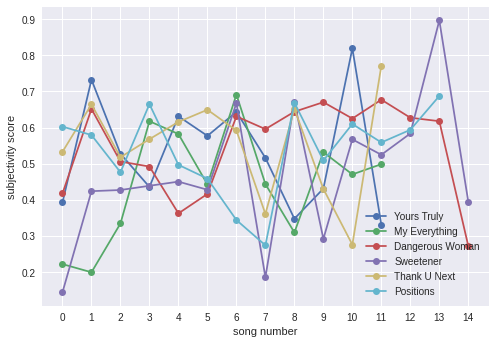

In [23]:
drawLinePlot(data, 'subjectivity')

It is worth noting that *Dangerous Woman* stays at a relatively constant level of subjectivity in the last half of the album. *My Everything* and *Sweetener* have similar highs and lows.

      album1    album2    album3    album4    album5    album6
0   0.392956  0.222222  0.417857  0.144444  0.532956  0.602671
1   0.732574  0.199589  0.651515  0.424030  0.664236  0.579350
2   0.527534  0.334667  0.505952  0.427212  0.517940  0.476389
3   0.435714  0.617593  0.492171  0.438937  0.568008  0.664776
4   0.631250  0.582143  0.362554  0.450427  0.615586  0.496836
5   0.577048  0.442778  0.416442  0.427976  0.649333  0.458812
6   0.643590  0.691353  0.631034  0.667696  0.591964  0.344152
7   0.516114  0.443842  0.595726  0.185640  0.361111  0.274306
8   0.347667  0.309697  0.643910  0.671296  0.651754  0.668971
9   0.431158  0.532024  0.670312  0.292113  0.430320  0.508917
10  0.819155  0.470385  0.625000  0.567381  0.275926  0.609910
11  0.330903  0.498810  0.677199  0.524722  0.771429  0.558838
12       NaN       NaN  0.627273  0.583660       NaN  0.593834
13       NaN       NaN  0.617702  0.896552       NaN  0.687446
14       NaN       NaN  0.272222  0.394617       NaN   

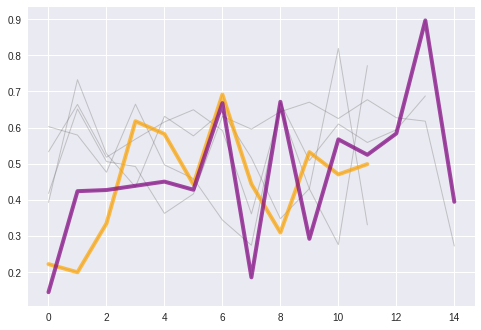

In [24]:
highlightAlbums(data, 'album2', 'album4', 'subjectivity')

## Word Frequency Analysis

Another interesting aspect of song lyrics is that we can analyze how often words occur. This can tell us more about the lexical diversity as well the artist's vocabulary and similarity of topics mentioned. 

**freqPlot()** will plot the top words in descending order.

In [25]:
def freqPlot(keys):
  
  plt.rcdefaults()
  fig, ax = plt.subplots()

  all_words = [x[0] for x in keys]
  freq = [x[1] for x in keys]
  y_pos = np.arange(len(all_words))

  ax.barh(y_pos, freq, align='center')
  ax.set_yticks(y_pos)
  ax.set_yticklabels(all_words)
  ax.invert_yaxis()  # labels read top-to-bottom
  ax.set_xlabel('Count')
  ax.set_title('Top Words')

  plt.show()
  plt.close(fig)

We can specify how many words we want to display by adjusting KEYS_PER_ALBUM. In the end, we'll assemble all of the keywords in a list.

In [26]:
def getTopKeywords(tokens, num):
  return Counter(tokens).most_common(num)

def keysToList(album_dict):

  my_tokens = getTokens(album_dict)

  #get tuple: (keys, freq)
  keys = getTopKeywords(my_tokens, KEYS_PER_ALBUM)
  
  freqPlot(keys)

  kw_list = []
  for pair in range(len(keys)):
    #access first word of tuple and append to local album keys list
    kw_list.append(keys[pair][0]) 

  kw_list = [str(k) for k in kw_list]
  kw_list = ",".join(kw_list)

  return str(kw_list)

Loop over all of the albums and display top words for each.

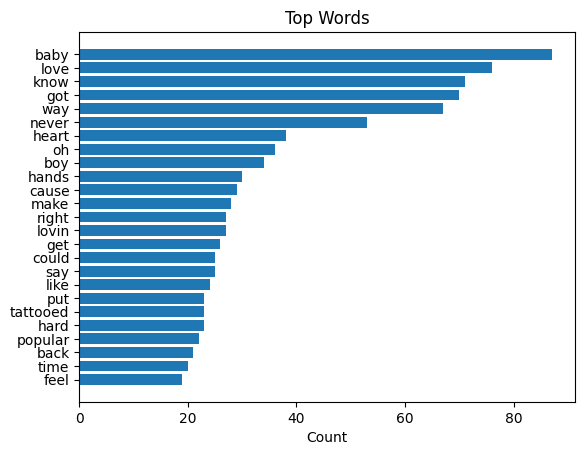

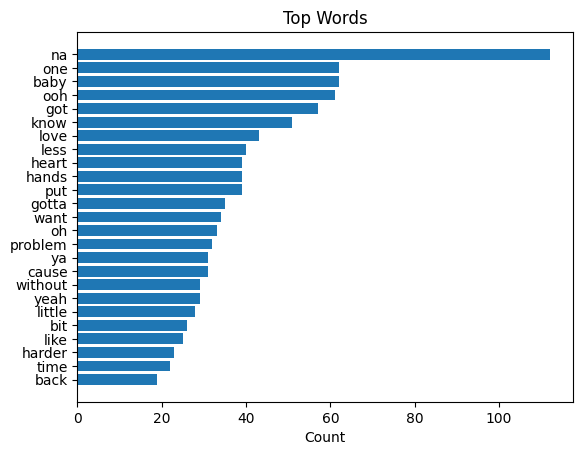

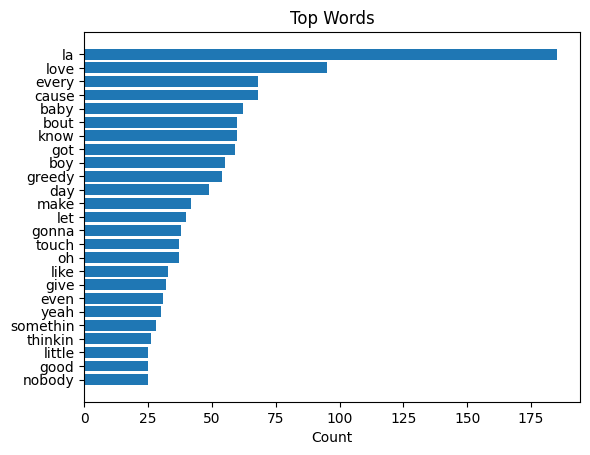

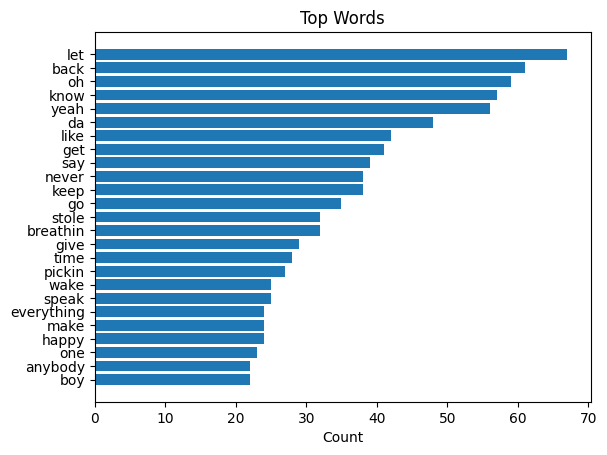

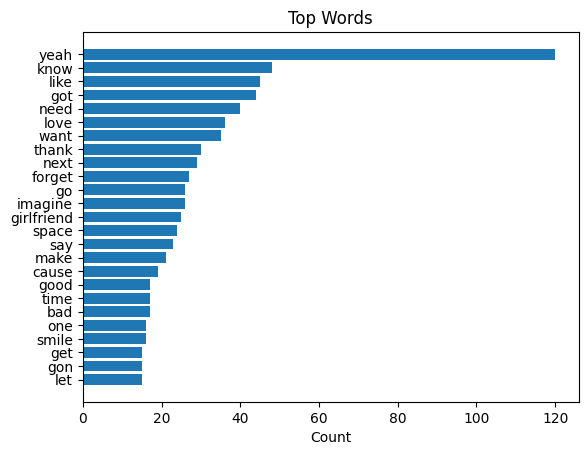

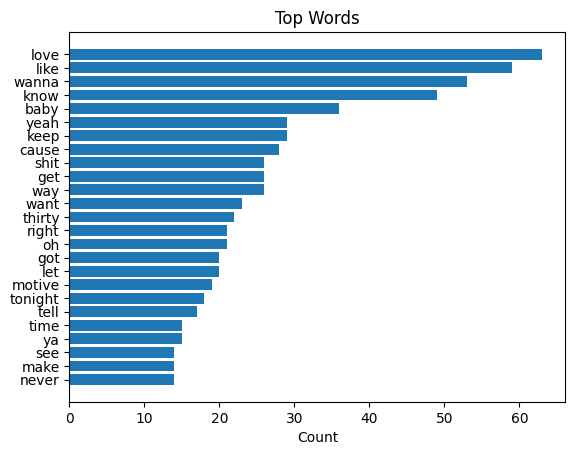

In [27]:
#Construct a list of all the keywords
all_keys = []  

for album in range(len(all_dicts)):
  # Grab keywords from each album and put them all in one list
  all_keys.append(keysToList(all_dicts[album]))

It seems like Ariana favors the word 'baby' in earlier albums while she uses 'yeah' in later albums.

## Visualizing with WordCloud

Word clouds give greater prominence to words that appear more frequently in the text. 

We will create a WordCloud for each album.

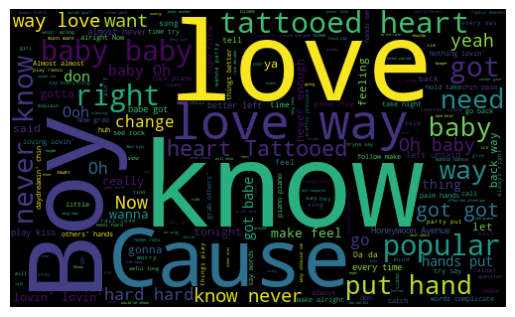

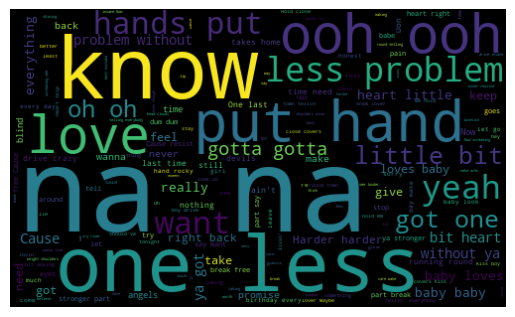

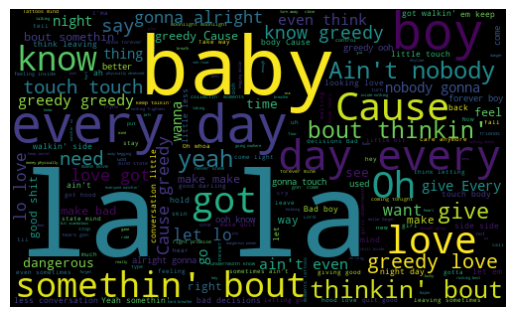

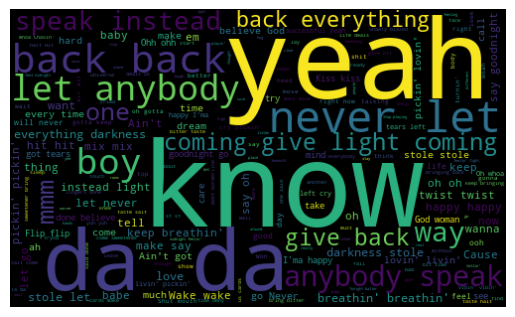

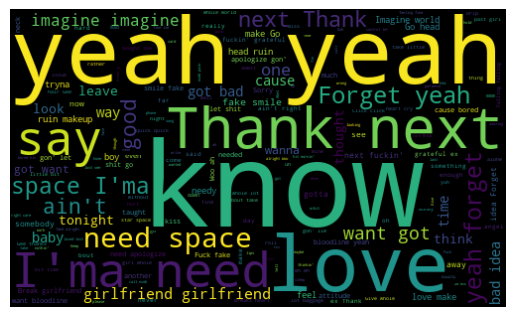

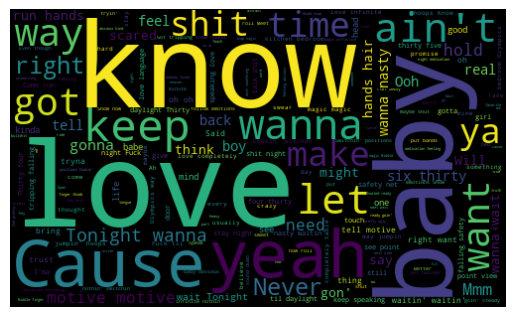

In [28]:
def showCloud(album_dict):

  all_words = joinWords(album_dict)

  #Construct WordCloud
  wordCloud = WordCloud(width=500,height=300,random_state=21, max_font_size=119).generate(all_words)

  fig = plt.imshow(wordCloud, interpolation="bilinear")
  plt.axis('off')
  plt.show()

for album in range(len(all_dicts)):
  showCloud(all_dicts[album])

Looking at the second, third, and fourth word clouds we can make an interesting observation.
*   "Na Na" is the most common bigram in *My Everything*
*   "La La" is the most common bigram in *Dangerous Woman*
*   "Da Da" is the most common bigram in *Sweetener*

It is worth noting that each of these bigrams are unique.





## Bigram Analysis

Now we will look at common bigrams, or pairs of consecutive words, appearing in the lyrics. Let's take a look at the last album.

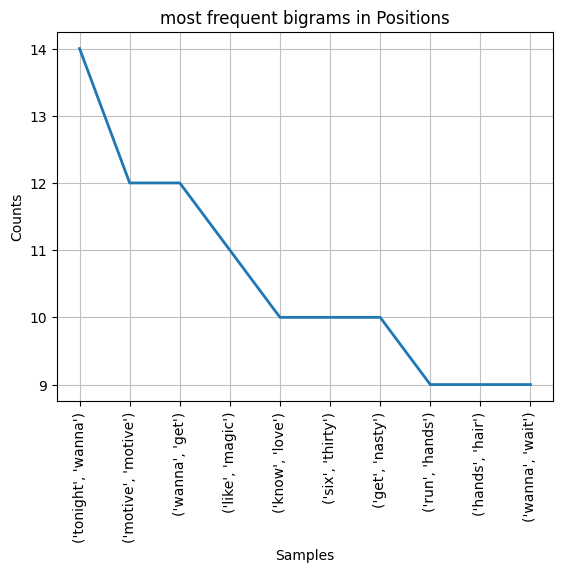

In [29]:
def bigramAnalysis(album_dict, title):

  tokens = getTokens(album_dict)
  #Create bigrams
  bgs = nltk.bigrams(tokens)
  #compute frequency distribution for all the bigrams in the text
  fdist = nltk.FreqDist(bgs)
  fdist.plot(10, title='most frequent bigrams in ' + title)


#take a look at bigrams for album 5
bigramAnalysis(all_dicts[5], 'Positions')

## Building a Semantic Network from a Co-Occurence Matrix

Representing the most common keywords as a co-occurence matrix will help us associate words that have a semantic relationship with each other. For our purpose, two words have a relationship if they are in the same sentence.

We will create a semantic network from the lyrics. Our goal is to use the network to help us detect topics in the lyrics and reveal clusters of similar words.

This section uses modified code from [Eric D. Brown](https://pythondata.com/text-analytics-visualization/).

In [30]:
#Put all the keywords in one column, creating a "document" matrix
album_df = pd.DataFrame(all_keys)

album_df.columns = ['document']

# Construct keywords df
kw_arr = []
#Iterate over each row
for index, row in album_df.iterrows():
  document = row['document'].split(',')
  for kw in document:
    kw_arr.append((kw.strip(' '), row['document']))

kw_df = pd.DataFrame(kw_arr)
kw_df = kw_df.rename(columns={0:'term', 1:'document'})


#kw_df contains 125 terms (column 0) and the document they are included in 
#(column1)

#We make a term-document (rows-cols) matrix
terms = kw_df.term.tolist()
documents = kw_df.document.tolist()

#doc arr contains a list of 125 lists containing 
doc_arr = []
for kw in documents:
  kws = kw.split(',')
  doc_arr.append(kws)


#We use an ordered dict to remember order of words inserted. initialize with 
#(term, term count)
occurrences = OrderedDict((term, OrderedDict((term, 0) for term in terms)) for term in terms)

# Loop over list of lists to find co-occurences
for group in doc_arr:
  for word in range(len(group)):
    for item in group[:word] + group[word + 1:]:
        #add one to the pair
        occurrences[group[word]][item] += 1

co_occur = pd.DataFrame.from_dict(occurrences)

co_occur.to_csv('term_frequency.csv')

The next step is to upload the csv file to Gephi, a network analysis and visualization platform.

To try it out for yourself, you can download Gephi
[here](https://gephi.org/users/download/) and produce the same graph that is in my github repository [here](https://github.com/tatianabarbone/text-analytics/blob/master/images/semantic-network.pdf).
